In [2]:
!pip install seaborn

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import DenseNet201, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


# --- KONFIGURASI GPU ---
# Kode ini mencegah GPU langsung memakan 100% VRAM saat inisialisasi
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

# Konfigurasi Seed agar hasil bisa direproduksi
print("Versi TF:", tf.__version__) # Harus 2.10.x
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Nama Device:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.random.set_seed(42)
np.random.seed(42)

Versi TF: 2.20.0
GPU Available: False
Nama Device: []
Num GPUs Available:  0


In [4]:
# Path Dataset (Sesuaikan dengan folder lokal Anda)
# Dataset harus memiliki struktur:
# DATA_DIR/
#   train/
#     normal/
#     benign/
#     malignant/
#   validation/
#     normal/
#     benign/
#     malignant/
#   test/
#     normal/
#     benign/
#     malignant/
DATA_DIR = "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parameter Gambar
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16  # Kurangi jika VRAM GPU < 4GB

# Hyperparameter dari Jurnal Hybrid Fusion
LEARNING_RATE = 0.0001  # Sesuai jurnal: 1e-4
DROPOUT_RATE = 0.4      # Dropout untuk fusion layer
EPOCHS = 100            # Dengan early stopping
NUM_CLASSES = 3         # Benign, Malignant, Normal


In [5]:
def apply_clahe_preprocessing(img):
    """
    Menerapkan CLAHE pada citra input.
    Input: Citra (numpy array), format RGB atau BGR.
    Output: Citra setelah CLAHE dan preprocess DenseNet.
    """
    # Pastikan tipe data uint8 untuk OpenCV
    img = img.astype('uint8')
    
    # 1. Konversi RGB ke LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # 2. Terapkan CLAHE pada channel L (Lightness)
    # Paper menyarankan clipLimit 2.0-4.0 dan grid 8x8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # 3. Gabungkan kembali
    limg = cv2.merge((cl, a, b))
    
    # 4. Konversi kembali ke RGB
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # 5. Preprocessing spesifik DenseNet (Scaling & Normalization)
    # Ini penting agar sesuai dengan bobot pre-trained ImageNet
    final_img = tf.keras.applications.densenet.preprocess_input(final_img)
    
    return final_img

print("Fungsi CLAHE siap digunakan.")

Fungsi CLAHE siap digunakan.


In [6]:
# Augmentasi Data Training dengan CLAHE
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe_preprocessing,  # CLAHE diterapkan di sini
    rotation_range=15,         # Rotasi +/- 15 derajat
    width_shift_range=0.1,     # Geser horizontal
    height_shift_range=0.1,    # Geser vertikal
    horizontal_flip=True,      # Flip kiri-kanan (Valid medis)
    vertical_flip=False,       # JANGAN flip vertikal (Bayangan akustik harus di bawah)
    zoom_range=0.2,            # Simulasi variasi ukuran tumor
    shear_range=0.1,           # Shear transformation
    fill_mode='nearest'
)

# Data Validasi dan Test - HANYA CLAHE, tanpa augmentasi
val_test_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe_preprocessing
)

# Generator Data Training
print("Menyiapkan Data Training...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,  # Sesuai jurnal: Batch size 32
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Generator Data Validasi
print("\nMenyiapkan Data Validasi...")
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,  # Sesuai jurnal: Batch size 32
    class_mode='categorical',
    shuffle=False
)

# Generator Data Test
print("\nMenyiapkan Data Test...")
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,  # Sesuai jurnal: Batch size 32
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"\nKelas yang ditemukan: {class_names}")
print(f"Total data training: {train_generator.samples}")
print(f"Total data validasi: {validation_generator.samples}")
print(f"Total data test: {test_generator.samples}")


Menyiapkan Data Training...
Found 824 images belonging to 3 classes.

Menyiapkan Data Validasi...
Found 113 images belonging to 3 classes.

Menyiapkan Data Validasi...
Found 113 images belonging to 3 classes.

Menyiapkan Data Test...
Found 93 images belonging to 3 classes.

Kelas yang ditemukan: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93

Menyiapkan Data Test...
Found 93 images belonging to 3 classes.

Kelas yang ditemukan: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93


In [7]:
def build_hybrid_model():
    """
    Hybrid Model: DenseNet201 + MobileNetV2 Fusion
    Sesuai jurnal "A Novel Convolutional Neural Networks Fusion"
    
    Arsitektur:
    1. Input yang sama masuk ke dua backbone berbeda
    2. DenseNet201: Ekstraktor fitur dalam dan kompleks
    3. MobileNetV2: Ekstraktor fitur ringan dan efisien
    4. Feature Fusion: Concatenate output kedua backbone
    5. Classification Head: Dropout + Dense Softmax
    """
    # 1. Input Layer (sama untuk kedua model)
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), name='input_image')
    
    # 2. Backbone 1: DenseNet201 (Deep & Dense Features)
    densenet_base = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'  # Global Average Pooling
    )
    densenet_base.trainable = False  # Freeze untuk transfer learning
    densenet_features = densenet_base.output  # Output shape: (None, 1920)
    
    # 3. Backbone 2: MobileNetV2 (Lightweight & Efficient Features)
    mobilenet_base = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'  # Global Average Pooling
    )
    mobilenet_base.trainable = False  # Freeze untuk transfer learning
    mobilenet_features = mobilenet_base.output  # Output shape: (None, 1280)
    
    # 4. Feature Fusion: Concatenate kedua vektor fitur
    # DenseNet: 1920 fitur + MobileNet: 1280 fitur = 3200 fitur gabungan
    fused_features = layers.concatenate(
        [densenet_features, mobilenet_features], 
        name='feature_fusion'
    )
    
    # 5. Classification Head
    # Dropout untuk regularisasi (mencegah overfitting)
    x = layers.Dropout(DROPOUT_RATE, name='fusion_dropout')(fused_features)
    
    # Output Layer: Softmax untuk multi-class classification
    outputs = layers.Dense(
        NUM_CLASSES, 
        activation='softmax', 
        name='output_prediction'
    )(x)
    
    # 6. Build Model
    model = Model(
        inputs=inputs, 
        outputs=outputs, 
        name="DenseNet201_MobileNetV2_Fusion"
    )
    
    return model

model = build_hybrid_model()
model.summary()

C:\Users\ihabh\AppData\Local\Temp\ipykernel_86904\2398725590.py:27: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "DenseNet201_MobileNetV2_Fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_image[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,589,571 (78.54 MB)

 Trainable params: 9,603 (37.51 KB)

 Non-trainable params: 20,579,968 (78.51 MB)

In [8]:
# 1. Definisi Callbacks
# ReduceLROnPlateau: Menurunkan learning rate jika val_accuracy tidak meningkat
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric yang dipantau
    factor=0.5,               # Faktor penurunan (LR baru = LR lama * 0.5)
    patience=5,               # Tunggu 5 epoch sebelum menurunkan LR
    min_lr=1e-7,              # Batas bawah LR
    verbose=1                 # Tampilkan pesan di output saat LR berubah
)

# ModelCheckpoint: Simpan model terbaik
checkpoint = ModelCheckpoint(
    'best_model_hybrid_fusion.keras',  # Nama file untuk hybrid model
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# EarlyStopping: Hentikan training jika tidak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=15,              # Lebih sabar untuk model yang lebih kompleks
    restore_best_weights=True,
    verbose=1
)

# 2. Compile Model dengan Adam Optimizer
print(f"🚀 Konfigurasi Optimizer: Adam (Sesuai Jurnal)")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Beta_1: 0.9, Beta_2: 0.999")

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Training
print(f"\n{'='*60}")
print(f"🎯 Mulai Training Hybrid Fusion Model")
print(f"   DenseNet201 + MobileNetV2 Feature Fusion")
print(f"{'='*60}")
print(f"Dataset: {DATA_DIR}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: 32")
print(f"Classes: {NUM_CLASSES} ({', '.join(class_names)})")
print(f"{'='*60}\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

print("\n✅ Training selesai!")


🚀 Konfigurasi Optimizer: Adam (Sesuai Jurnal)
   Learning Rate: 0.0001
   Beta_1: 0.9, Beta_2: 0.999

🎯 Mulai Training Hybrid Fusion Model
   DenseNet201 + MobileNetV2 Feature Fusion
Dataset: D:\Kuliah\Semester 5\HUMIC\dataset gabungan
Epochs: 100
Batch Size: 32
Classes: 3 (benign, malignant, normal)

Epoch 1/100
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4145 - loss: 1.2602
Epoch 1: val_accuracy improved from None to 0.66667, saving model to best_model_hybrid_fusion.keras

Epoch 1: val_accuracy improved from None to 0.66667, saving model to best_model_hybrid_fusion.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4457 - loss: 1.2176 - val_accuracy: 0.6667 - val_loss: 0.7469 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4457 - loss: 1.2176 - val_accuracy: 0.6667 - val_loss: 0.7469 - learning_rate: 1.0000e-04
Epoch 2/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3438 - loss: 1.3099

d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.66667
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.3438 - loss: 1.3099 - val_accuracy: 0.6667 - val_loss: 0.7464 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.3438 - loss: 1.3099 - val_accuracy: 0.6667 - val_loss: 0.7464 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4670 - loss: 1.2473
Epoch 3: val_accuracy improved from 0.66667 to 0.67708, saving model to best_model_hybrid_fusion.keras

Epoch 3: val_accuracy improved from 0.66667 to 0.67708, saving model to best_model_hybrid_fusion.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4722 - loss: 1.1646 - val_accuracy: 0.6771 - val_loss: 0.7498 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4722 - loss: 1.1646 - val_accuracy: 0.6771 - val_loss: 0.7498 - learning_rate: 1.0000e-04
Epoch 4/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accu

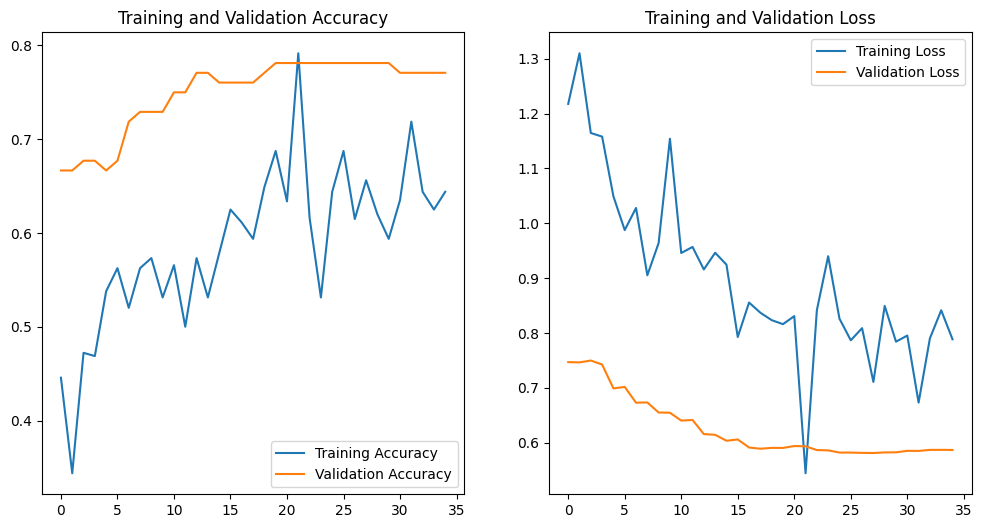

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
# ===================================================================
# EVALUASI MODEL PADA DATA TEST
# ===================================================================

print("🔍 Evaluasi Model pada Data Test...")

# Load model terbaik
best_model = tf.keras.models.load_model('best_model_hybrid_fusion.keras')

# Reset generator untuk memastikan dimulai dari awal
test_generator.reset()

# Prediksi pada data test
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = best_model.predict(test_generator, steps=test_steps, verbose=1)

# Dapatkan kelas prediksi dan kelas sebenarnya
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Pastikan jumlah prediksi sesuai dengan jumlah data test
# (prediksi bisa lebih banyak karena batch terakhir dibulatkan ke atas)
predicted_classes = predicted_classes[:len(true_classes)]

print(f"\n✅ Evaluasi selesai!")
print(f"Total sampel test: {test_generator.samples}")
print(f"Total prediksi: {len(predicted_classes)}")
print(f"Total true labels: {len(true_classes)}")


🔍 Evaluasi Model pada Data Test...
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93


In [11]:
# ===================================================================
# PERHITUNGAN METRIK EVALUASI
# ===================================================================

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Hitung metrik untuk setiap kelas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)

# Hitung metrik rata-rata
precision_avg = precision_score(true_classes, predicted_classes, average='weighted')
recall_avg = recall_score(true_classes, predicted_classes, average='weighted')
f1_avg = f1_score(true_classes, predicted_classes, average='weighted')

# Tampilkan hasil
print("=" * 70)
print("HASIL EVALUASI MODEL PADA DATA TEST")
print("=" * 70)
print(f"\n📊 Overall Metrics:")
print(f"  Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision : {precision_avg:.4f}")
print(f"  Recall    : {recall_avg:.4f}")
print(f"  F1-Score  : {f1_avg:.4f}")

print(f"\n📊 Per-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\n  {class_name.upper()}:")
    print(f"    Precision : {precision[i]:.4f}")
    print(f"    Recall    : {recall[i]:.4f}")
    print(f"    F1-Score  : {f1[i]:.4f}")

print("\n" + "=" * 70)


HASIL EVALUASI MODEL PADA DATA TEST

📊 Overall Metrics:
  Accuracy  : 0.7204 (72.04%)
  Precision : 0.7795
  Recall    : 0.7204
  F1-Score  : 0.6902

📊 Per-Class Metrics:

  BENIGN:
    Precision : 0.6508
    Recall    : 0.9318
    F1-Score  : 0.7664

  MALIGNANT:
    Precision : 0.8571
    Recall    : 0.6667
    F1-Score  : 0.7500

  NORMAL:
    Precision : 1.0000
    Recall    : 0.1538
    F1-Score  : 0.2667



In [12]:
# ===================================================================
# CLASSIFICATION REPORT
# ===================================================================

print("📋 Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_names, digits=4)
print(report)

# Simpan report sebagai dictionary untuk visualisasi nanti
from sklearn.metrics import classification_report
report_dict = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)


📋 Classification Report:

              precision    recall  f1-score   support

      benign     0.6508    0.9318    0.7664        44
   malignant     0.8571    0.6667    0.7500        36
      normal     1.0000    0.1538    0.2667        13

    accuracy                         0.7204        93
   macro avg     0.8360    0.5841    0.5943        93
weighted avg     0.7795    0.7204    0.6902        93



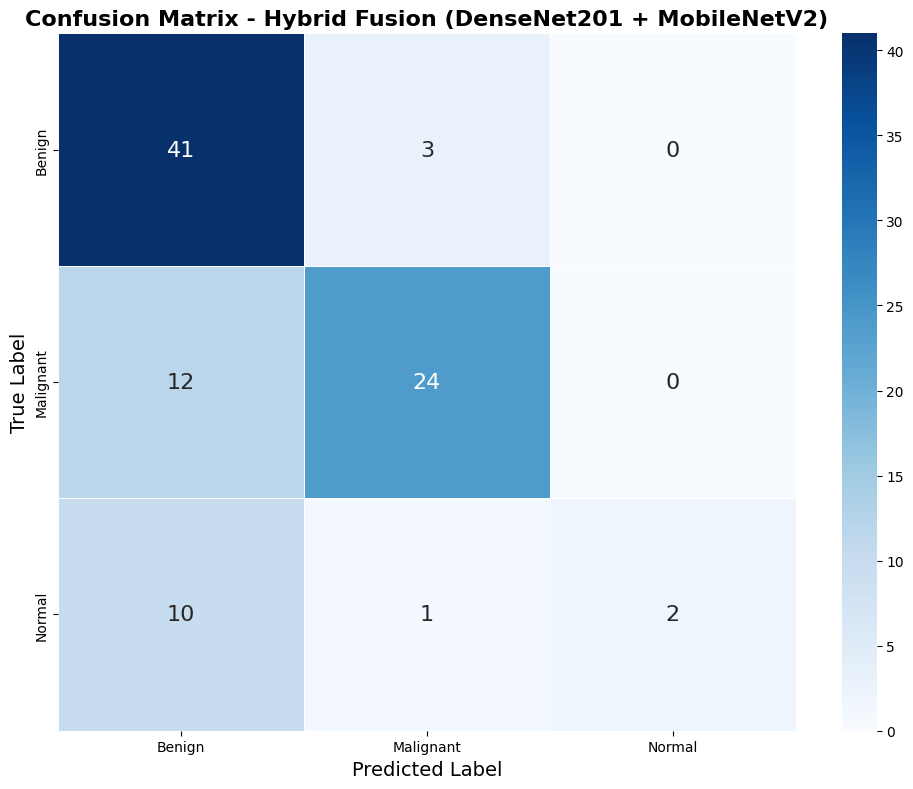

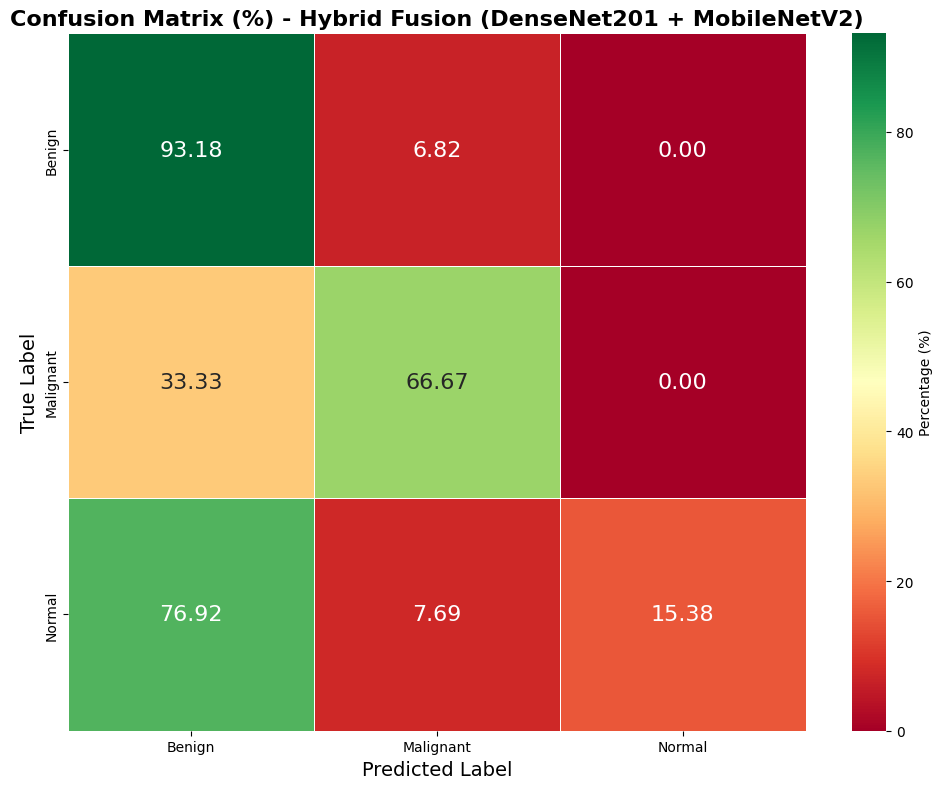

In [13]:
# ===================================================================
# CONFUSION MATRIX VISUALIZATION
# ===================================================================

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16})

plt.title('Confusion Matrix - Hybrid Fusion (DenseNet201 + MobileNetV2)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Tampilkan confusion matrix dalam bentuk persentase
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16}, cbar_kws={'label': 'Percentage (%)'})

plt.title('Confusion Matrix (%) - Hybrid Fusion (DenseNet201 + MobileNetV2)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()


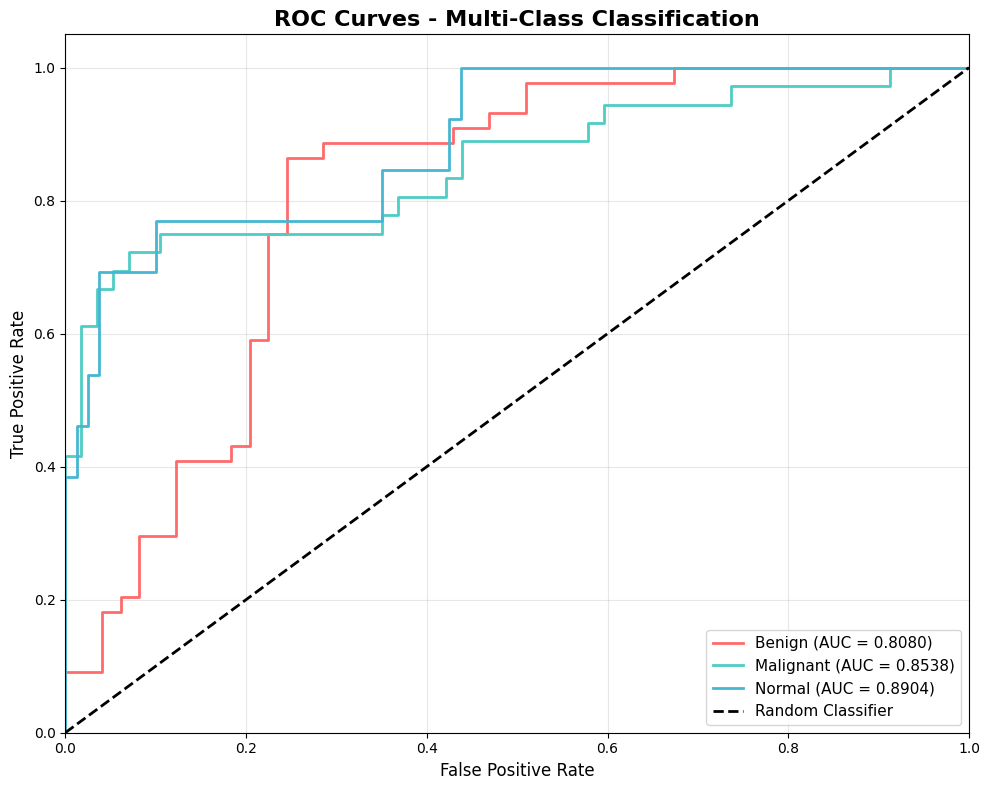

📊 AUC Scores:
  Benign: 0.8080
  Malignant: 0.8538
  Normal: 0.8904


In [14]:
# ===================================================================
# ROC CURVE & AUC SCORE (Multi-Class)
# ===================================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels untuk ROC multi-class
y_test_binarized = label_binarize(true_classes, classes=range(NUM_CLASSES))
y_score = predictions[:test_generator.samples]

# Compute ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i].capitalize()} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name.capitalize()}: {roc_auc[i]:.4f}")


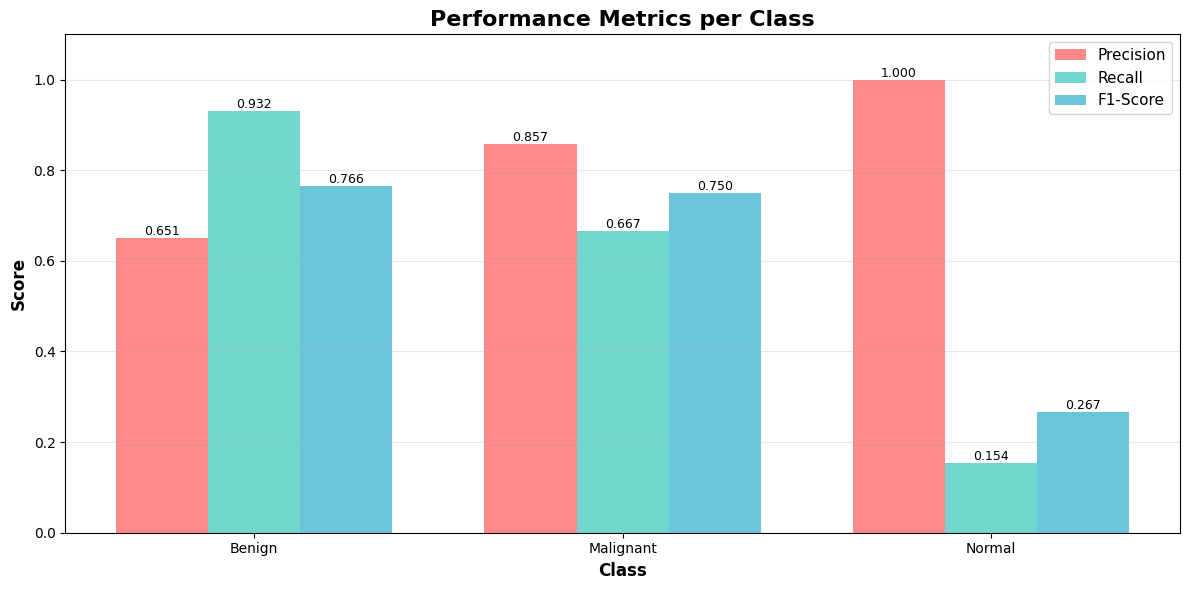

In [15]:
# ===================================================================
# METRIK PER-CLASS VISUALIZATION (Bar Charts)
# ===================================================================

# Prepare data
metrics_data = {
    'Class': [c.capitalize() for c in class_names],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_data)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', color='#4ECDC4', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#45B7D1', alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics per Class', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.capitalize() for c in class_names])
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [16]:
# ===================================================================
# SUMMARY TABLE - COMPREHENSIVE RESULTS
# ===================================================================

import pandas as pd

# Create comprehensive summary table
summary_data = []
for i, class_name in enumerate(class_names):
    summary_data.append({
        'Class': class_name.capitalize(),
        'Precision': f"{precision[i]:.4f}",
        'Recall': f"{recall[i]:.4f}",
        'F1-Score': f"{f1[i]:.4f}",
        'Support': int(cm[i].sum())
    })

# Add overall metrics
summary_data.append({
    'Class': 'OVERALL (Weighted)',
    'Precision': f"{precision_avg:.4f}",
    'Recall': f"{recall_avg:.4f}",
    'F1-Score': f"{f1_avg:.4f}",
    'Support': int(cm.sum())
})

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("📊 COMPREHENSIVE EVALUATION SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Display as styled table
from IPython.display import display
styled_df = df_summary.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt',
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4ECDC4'), ('color', 'white'), 
                                  ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:last-child', 'props': [('background-color', '#FFE66D'), ('font-weight', 'bold')]}
])

display(styled_df)



📊 COMPREHENSIVE EVALUATION SUMMARY
             Class Precision Recall F1-Score  Support
            Benign    0.6508 0.9318   0.7664       44
         Malignant    0.8571 0.6667   0.7500       36
            Normal    1.0000 0.1538   0.2667       13
OVERALL (Weighted)    0.7795 0.7204   0.6902       93


,Class,Precision,Recall,F1-Score,Support
0,Benign,0.6508,0.9318,0.7664,44
1,Malignant,0.8571,0.6667,0.7500,36
2,Normal,1.0000,0.1538,0.2667,13
3,OVERALL (Weighted),0.7795,0.7204,0.6902,93


In [17]:
# ===================================================================
# TRAINING HISTORY ANALYSIS
# ===================================================================

# Create detailed training history table
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Train Accuracy': [f"{acc:.4f}" for acc in history.history['accuracy']],
    'Val Accuracy': [f"{acc:.4f}" for acc in history.history['val_accuracy']],
    'Train Loss': [f"{loss:.4f}" for loss in history.history['loss']],
    'Val Loss': [f"{loss:.4f}" for loss in history.history['val_loss']]
})

print("\n📈 TRAINING HISTORY (First and Last 5 Epochs):")
print("="*80)
print("First 5 Epochs:")
print(history_df.head().to_string(index=False))
print("\nLast 5 Epochs:")
print(history_df.tail().to_string(index=False))
print("="*80)

# Find best epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])

print(f"\n🏆 Best Epoch: {best_epoch}")
print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")



📈 TRAINING HISTORY (First and Last 5 Epochs):
First 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
     1         0.4457       0.6667     1.2176   0.7469
     2         0.3438       0.6667     1.3099   0.7464
     3         0.4722       0.6771     1.1646   0.7498
     4         0.4688       0.6771     1.1580   0.7425
     5         0.5379       0.6667     1.0491   0.6990

Last 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
    31         0.6351       0.7708     0.7953   0.5852
    32         0.7188       0.7708     0.6731   0.5851
    33         0.6439       0.7708     0.7902   0.5869
    34         0.6250       0.7708     0.8414   0.5870
    35         0.6439       0.7708     0.7885   0.5868

🏆 Best Epoch: 20
   Best Validation Accuracy: 0.7812 (78.12%)


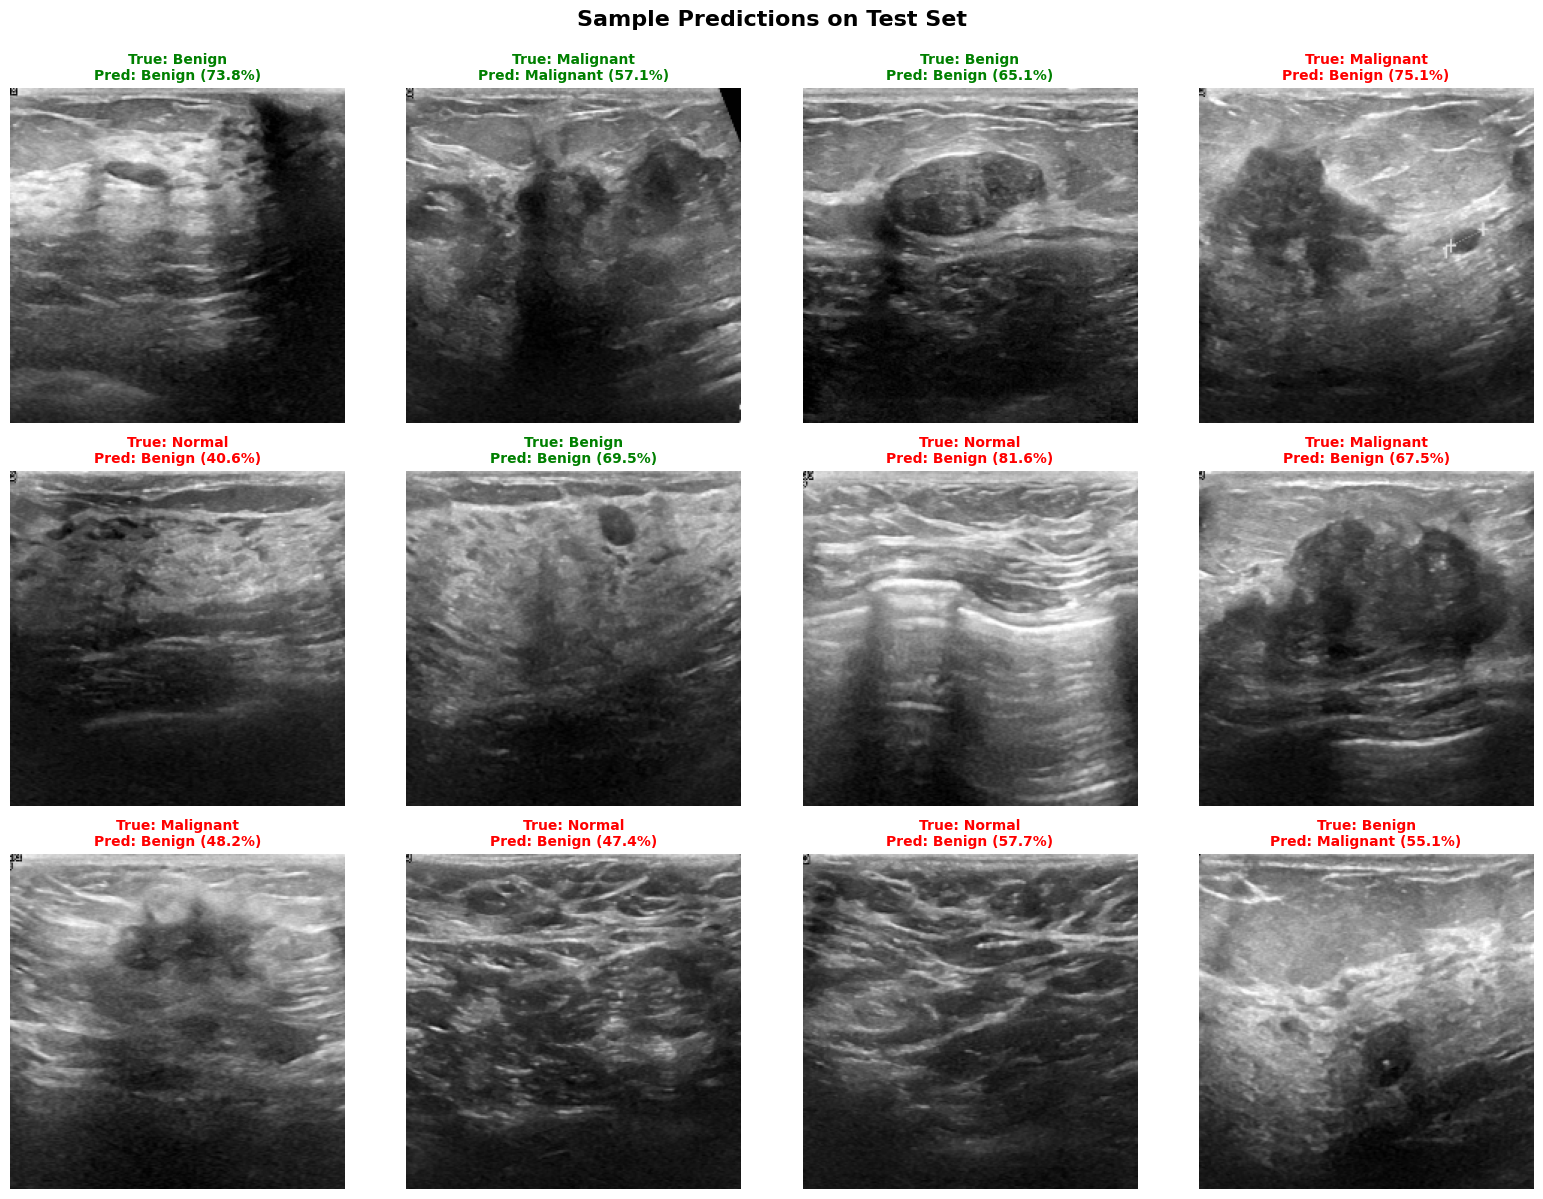

In [18]:
# ===================================================================
# SAMPLE PREDICTIONS VISUALIZATION
# ===================================================================

import random

# Get random samples from test set
num_samples = 12
test_files = []
test_labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(TEST_DIR, class_name)
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for file in files[:4]:  # 4 samples per class
        test_files.append(file)
        test_labels.append(class_idx)

# Shuffle
combined = list(zip(test_files, test_labels))
random.shuffle(combined)
test_files, test_labels = zip(*combined)
test_files = list(test_files[:num_samples])
test_labels = list(test_labels[:num_samples])

# Create predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, (img_path, true_label) in enumerate(zip(test_files, test_labels)):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Apply preprocessing
    img_processed = apply_clahe_preprocessing(img_resized)
    img_array = np.expand_dims(img_processed, axis=0)
    
    # Predict
    pred = best_model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred[0])
    confidence = pred[0][pred_class]
    
    # Display
    axes[idx].imshow(img_resized)
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_class == true_label else 'red'
    title = f"True: {class_names[true_label].capitalize()}\n"
    title += f"Pred: {class_names[pred_class].capitalize()} ({confidence*100:.1f}%)"
    
    axes[idx].set_title(title, color=color, fontweight='bold', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [19]:
# ===================================================================
# FINAL SUMMARY REPORT
# ===================================================================

print("\n" + "="*80)
print("🎯 FINAL EVALUATION REPORT - Hybrid Fusion Model")
print("   DenseNet201 + MobileNetV2 Feature Fusion")
print("="*80)

print("\n📁 Dataset Information:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {validation_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Classes: {', '.join([c.capitalize() for c in class_names])}")

print("\n🏗️ Model Architecture:")
print(f"   Backbone 1: DenseNet201 (Pre-trained on ImageNet)")
print(f"   Backbone 2: MobileNetV2 (Pre-trained on ImageNet)")
print(f"   Fusion Method: Feature Concatenation (3200 features)")
print(f"   Dropout Rate: {DROPOUT_RATE}")

print("\n⚙️ Training Configuration:")
print(f"   Optimizer: Adam")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Batch Size: 32")
print(f"   Epochs Trained: {len(history.history['accuracy'])}")
print(f"   Best Epoch: {best_epoch}")

print("\n🔬 Preprocessing:")
print(f"   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)")
print(f"   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)")

print("\n📊 Test Set Performance:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision (Weighted): {precision_avg:.4f}")
print(f"   Recall (Weighted): {recall_avg:.4f}")
print(f"   F1-Score (Weighted): {f1_avg:.4f}")

print("\n📈 Per-Class F1-Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {f1[i]:.4f}")

print("\n🎯 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {roc_auc[i]:.4f}")

print("\n" + "="*80)
print("✅ Evaluation Complete!")
print("="*80)



🎯 FINAL EVALUATION REPORT - Hybrid Fusion Model
   DenseNet201 + MobileNetV2 Feature Fusion

📁 Dataset Information:
   Training samples: 824
   Validation samples: 113
   Test samples: 93
   Classes: Benign, Malignant, Normal

🏗️ Model Architecture:
   Backbone 1: DenseNet201 (Pre-trained on ImageNet)
   Backbone 2: MobileNetV2 (Pre-trained on ImageNet)
   Fusion Method: Feature Concatenation (3200 features)
   Dropout Rate: 0.4

⚙️ Training Configuration:
   Optimizer: Adam
   Learning Rate: 0.0001
   Batch Size: 32
   Epochs Trained: 35
   Best Epoch: 20

🔬 Preprocessing:
   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)
   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)

📊 Test Set Performance:
   Accuracy: 0.7204 (72.04%)
   Precision (Weighted): 0.7795
   Recall (Weighted): 0.7204
   F1-Score (Weighted): 0.6902

📈 Per-Class F1-Scores:
   Benign: 0.7664
   Malignant: 0.7500
   Normal: 0.2667

🎯 AUC Scores:
   Benign: 0.8080
   Malignant: 0.8538
   Normal: 0.8904

✅

In [20]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block32_concat", pred_index=None):
    # 1. Buat model yang memetakan input ke aktivasi layer konvolusi terakhir dan output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Rekam gradien
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. Hitung gradien output terhadap feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # 4. Global Average Pooling pada gradien
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Kalikan feature map dengan bobot gradien
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalisasi Heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model):
    # Load Image manual
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Preprocess
    img_processed = apply_clahe_preprocessing(original_img)
    img_array = np.expand_dims(img_processed, axis=0)

    # Hapus softmax di layer terakhir agar gradien lebih tajam (opsional tapi disarankan)
    model.layers[-1].activation = None

    # Generate Heatmap
    # Layer 'conv5_block32_concat' adalah layer output terakhir DenseNet201
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block32_concat")

    # Tampilkan
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Citra Asli")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # Overlay
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# --- CONTOH PENGGUNAAN ---
# Ganti dengan path file gambar USG asli yang ingin dites
# display_gradcam("dataset/malignant/malignant (10).png", best_model)